## Setup autoreload, warnings and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


## Imports

In [20]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import config
from argparse import ArgumentParser
from pathlib import Path

from config import config
from pathlib import Path
import numpy as np
import tarfile, zipfile
import tensorflow as tf
from PIL import Image 


from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice, SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_dataset, get_save_step, apply_sequential, curry_sequential, print_topk_accuracy
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, identify, identify_single, encode_dataset, apply_geometric
from reidentification.find_matches import find_matches
from segmentation.segmentation import segment
from reidentification.visualisation import visualise_match
import pickle

## Create a configuration file.
You can change the default parameters in config.py

In [51]:
cfg = config()

## Download the dataset

## Create dataset variables

In [41]:
image1_path = "/ekaterina/work/data/Norppa_dataset_segmented_publ_crop/database/phs161/64357679-1b01-42fd-94e2-9c09952e67cd-master.jpg.result.png"
image2_path = "/ekaterina/work/data/Norppa_dataset_segmented_publ_crop/query/phs161/c7a68310-6e40-43fa-b401-a8352fa04488-halfpage.jpg.result.png"



## Show an image from the dataset

# Img 1

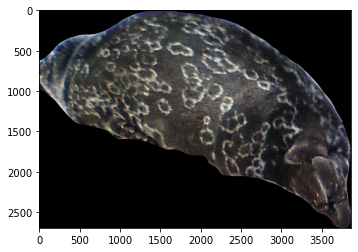

# Img 2

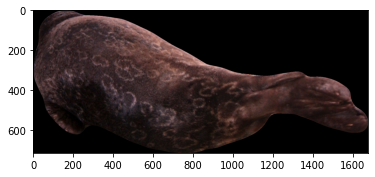

In [42]:
print_heading("Img 1")
image1 = Image.open(image1_path)
plt.imshow(image1)
plt.show()

print_heading("Img 2")
image2 = Image.open(image2_path)
plt.imshow(image2)
plt.show()

In [43]:
extract_pattern_step = curry_sequential(extract_pattern, model=cfg["unet"])
segment_step = curry_sequential(segment, predictor=cfg["detectron_predictor"])

pipeline = [
    # Pattern extraction                                       
    apply_sequential(crop_step),                               # 7
    extract_pattern_step,                                      # 8
    # Identification                                           
    curry(encode_dataset, cfg, compute_codebooks=False)         # 11
]
label1 = {"group_label":"file", "file": image1_path, "class_id": 0}
label2 = {"group_label":"file", "file": image2_path, "class_id": 0}
dataset = [(image1, label1), (image2, label2)]
encoded = apply_pipeline_dataset(dataset, pipeline, True)


Completed 1/3 steps
Completed 2/3 steps


  0%|                                                     | 0/2 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]

Calculating PCA
Getting encoding parameters...
Encoding...
Completed 3/3 steps


1


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 16743.73it/s]

Completed 1/4 steps


Completed 2/4 steps
Completed 3/4 steps


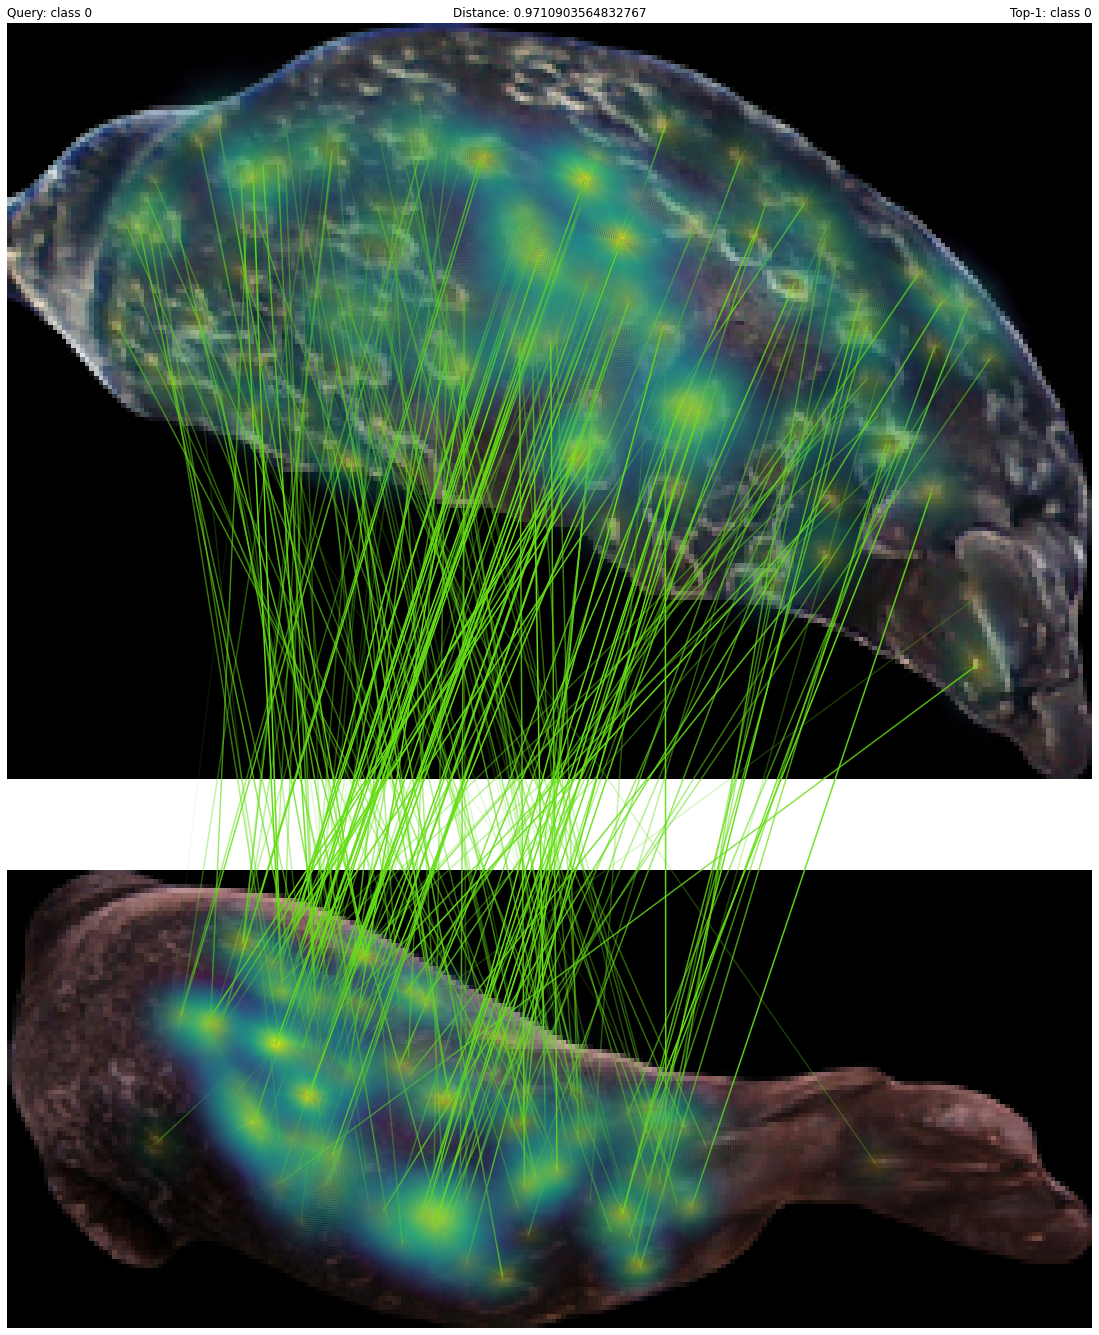

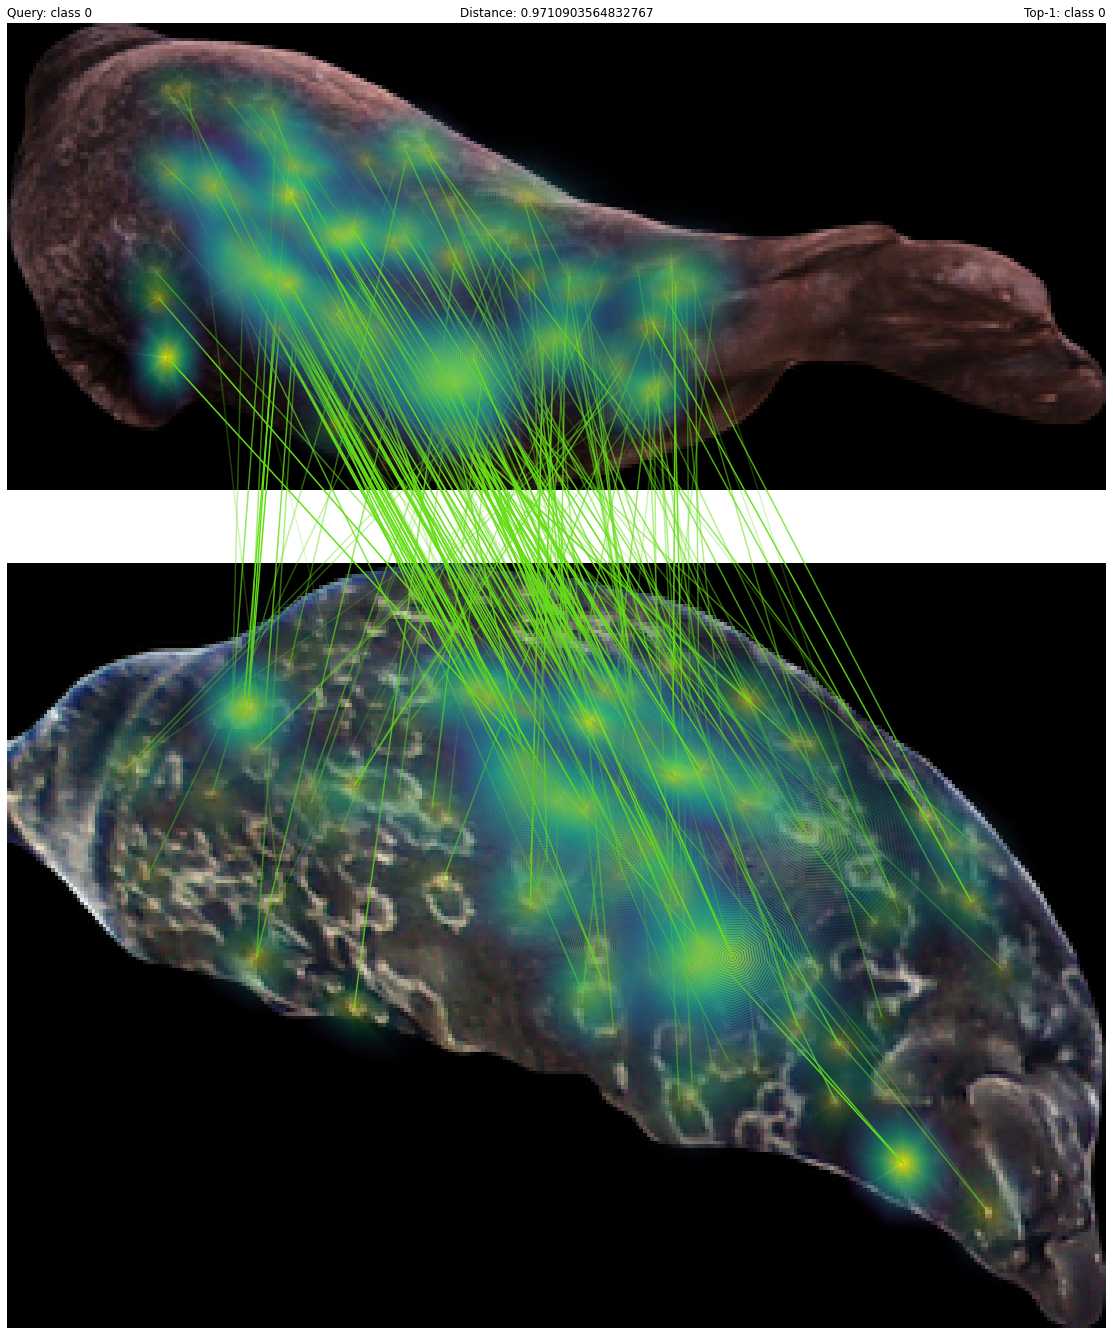

Completed 4/4 steps


In [69]:

identify_pipeline = [
        curry(identify, encoded, 1, leave_one_out=True),
        curry_sequential(find_matches, cfg),
        curry_sequential(apply_geometric, cfg["geometric"]),
        curry_sequential(visualise_match, 1)
]
    
result = apply_pipeline_dataset(encoded, identify_pipeline, True)


In [54]:

print(len(matches))

1


In [73]:
from reidentification.visualisation import *

def draw_features(input, topk=1, path_to_load="file", uncropped=True, gap=20, n_rad=50, n_pts=10, figsize=(24, 24), inlier_color=(0.4,0.87,0.09), outlier_color=(.87, .09, .09), in_cmap="cividis", out_cmap= "inferno", filename="features.png", filtering_func=lambda match, query_label: True):
    matches, query_labels = input
    
    for k, match in enumerate(matches[0:topk]):
        db_label = match["db_label"]
        query_label = query_labels["labels"][match["query_ind"]]
        
        if not filtering_func(match, query_label):
            continue
        
        fig = plt.figure(figsize=figsize)
        query_img, query_shift, query_ratio = prepare_query(query_label, uncropped, path_to_load)
        
        query_patches, db_patches, similarity = match["patches"]
        
    
        full_img = Image.new('RGB', query_img.size, color="white")
        full_img.paste(query_img, (0, 0))
        
        colors = plt.get_cmap("viridis", n_rad)
        
        colors_in = plt.get_cmap(in_cmap, n_rad)
        
        plt.axis("off")
        plt.imshow(full_img)
        
        mask = match.get("Mask", np.full(len(query_patches), True)).squeeze()
#         print("Mask" in match)
#         print(mask)
        
      # Separating inliers and outliers
           
        inliers_qr = [point for point, i in zip(query_patches, mask) if i == 1]
        inliers_db = [point for point, i in zip(db_patches, mask) if i == 1]
        
        outliers_qr = [point for point, i in zip(query_patches, mask) if i == 0]
        outliers_db = [point for point, i in zip(db_patches, mask) if i == 0]
        
        
        # Plotting outliers first
        for LAF_q, sim in zip(query_patches, similarity):
            # Intensity depends on feature similarity
    
            # max opacity can be determined with the similarity parameter as well. The same applies to inlier plot loop. 
            max_opacity = sim*2 # .4
            
            p1 = ell2plotMatch(plt, LAF_q, colors_in, shift=query_shift,n_rad=n_rad, max_opacity=max_opacity, n_pts=n_pts)
            
            # draw line between patch centers
            
#         plt.show()
        plt.savefig('features.png')
        plt.close(fig)
        
    return [input]
            
            
            
    

In [74]:
draw_features(result[0])

[([{'db_label': {'labels': [{'group_label': 'file',
       'file': '/ekaterina/work/data/Norppa_dataset_segmented_publ_crop/query/phs161/c7a68310-6e40-43fa-b401-a8352fa04488-halfpage.jpg.result.png',
       'class_id': 0,
       'bb': (0, 0, 1675, 712),
       'resize_ratio': 0.17893209683384062,
       'id': 1,
       'features': array([[-0.43229976,  0.5833232 , -0.00571487, ..., -0.16090797,
               -1.5523638 , -1.1171539 ],
              [-1.3285276 ,  0.88525003,  1.875368  , ...,  0.757549  ,
               -0.6978039 , -0.05610902],
              [-1.1390554 ,  1.0867137 , -0.30243322, ...,  0.69899535,
                1.2490805 , -0.26938558],
              ...,
              [ 1.3504997 ,  0.57264   , -2.1419637 , ...,  0.7532715 ,
                0.7699461 ,  0.49305058],
              [-0.27532127, -0.07061091,  0.21569698, ...,  1.3978515 ,
               -0.9295744 , -0.1172891 ],
              [ 0.23953979,  0.1528349 ,  1.2406286 , ..., -0.4502231 ,
             